In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib

# Load data
df = pd.read_csv("../data/OnlineRetail.csv", encoding='ISO-8859-1')

# Check column names
expected_columns = ["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"]
assert all(col in df.columns for col in expected_columns), "Missing required columns in the dataset"

# Calculate Revenue (Quantity * UnitPrice)
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Remove negative values (e.g., returns)
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Drop missing CustomerID (required for RFM)
df = df.dropna(subset=["CustomerID"])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [76]:
# Define cutoff date (last transaction date in dataset)
cutoff_date = df["InvoiceDate"].max()  # Example: '2011-12-31'

# Calculate last purchase date per customer
customer_last_purchase = df.groupby("CustomerID")["InvoiceDate"].max().reset_index()

# Label churned customers (inactive for >6 months)
customer_last_purchase["Churned"] = (cutoff_date - customer_last_purchase["InvoiceDate"]) > pd.Timedelta(days=180)
customer_last_purchase["Churned"] = customer_last_purchase["Churned"].astype(int)

In [77]:
# Aggregate RFM features
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (cutoff_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Revenue", "sum")
).reset_index()

# Merge churn labels
rfm = rfm.merge(customer_last_purchase[["CustomerID", "Churned"]], on="CustomerID")
rfm = rfm.dropna()

In [78]:
# Step 4: Train-Test Split with Stratification
X = rfm[["Recency", "Frequency", "Monetary"]]
y = rfm["Churned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [79]:
# Train Random Forest with class weights to handle imbalance
model = RandomForestClassifier(max_depth=5, class_weight="balanced")
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [80]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Step 6: Train Model with Regularization [[6]][[7]]
model = RandomForestClassifier(
    max_depth=5,              
    min_samples_leaf=10,       
    class_weight="balanced",   # Handle class imbalance
    random_state=42
)
model.fit(X_res, y_res)  # Train on resampled data

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, random_state=42)

In [81]:
cv_scores = cross_val_score(model, X, y, cv=StratifiedKFold(5), scoring="roc_auc")
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC:", np.mean(cv_scores))

Cross-Validation ROC-AUC Scores: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC: 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      1.00      1.00       172

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

ROC-AUC: 1.0


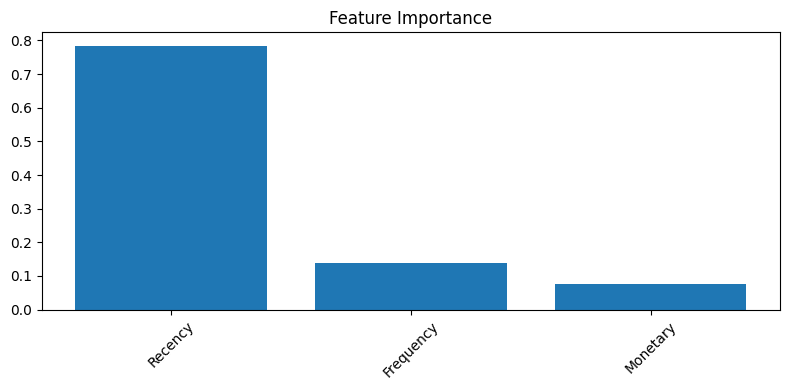

['../models/churn_prediction_model.pkl']

In [82]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

#Feature Importance Analysis
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

#Save Model
joblib.dump(model, "../models/churn_prediction_model.pkl")